In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
# Define the file path
file_path = "/Users/Zachary/Library/CloudStorage/OneDrive-UniversityofCambridge/Project/Data/240605_2nd_assay/plate5.txt"

# Read the file
with open(file_path, 'r', encoding='latin1') as file:
    lines = file.readlines()

# Extract metadata
metadata = lines[:4]

from io import StringIO
# Extract headers and data
headers = lines[4].strip().split('\t')
data = ''.join(lines[4:])

# Create a dataframe
df = pd.read_csv(StringIO(data), sep='\t')

# Filter out any rows where 'Time(hh:mm:ss)' is not in the correct format
df = df[:61]

df['Time(s)'] = df['Time(hh:mm:ss)'].apply(lambda x: sum(int(t) * 60 ** i for i, t in enumerate(reversed(x.split(':')))))

df = df.drop(columns=['Time(hh:mm:ss)', 'Temperature(¡C)', 'Unnamed: 98'])

# Extract time and well data
time_data = df['Time(s)']
well_data = df.drop(columns=['Time(s)'])


In [3]:
# Function to calculate the slope and evaluate the goodness of fit
# Swap columns 3 and 4 in each row

def calculate_slope(time_data, absorbance_data, start_time, end_time, threshold=0.95):
    # Filter the data for the given time window
    mask = (time_data >= start_time) & (time_data <= end_time)
    x = time_data[mask].values.reshape(-1, 1)
    y = absorbance_data[mask].values
    
    # Perform linear regression
    model = LinearRegression().fit(x, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(x, y)
    
    # Check the goodness of fit
    if r_squared < threshold:
        return None, r_squared
    return slope, r_squared

# Assuming df is your cleaned dataframe with 61 rows and 97 columns
# The last column is 'Time' and the rest are well data (A1 to H12)
time_data = df['Time(s)']
well_data = df.drop(columns=['Time(s)'])

# Dictionary to store slopes and R-squared values
slopes = {}
r_squared_values = {}

# Plot each well in a subplot and calculate the slope
for well in well_data.columns:
    slope, r_squared = None, 0
    start_time, end_time = 150,180
    
    # Adjust the window if the goodness of fit is not satisfactory
    while r_squared < 0.95 and end_time <= 600:
        slope, r_squared = calculate_slope(time_data, df[well], start_time, end_time)
        if slope is not None:
            break
        start_time += 10
        end_time += 10
    
    # Store the results
    slopes[well] = slope
    r_squared_values[well] = r_squared

# Display the slopes and R-squared values
slopes_df = pd.DataFrame({'Well': list(slopes.keys()), 'Slope': list(slopes.values()), 'R_squared': list(r_squared_values.values())})

# Print the dataframe
print(slopes_df)

   Well     Slope  R_squared
0    A1 -0.000014   0.980000
1    A2 -0.000050   0.961538
2    A3 -0.000026   0.965714
3    A4 -0.000375   0.979999
4    A5 -0.000251   0.979265
..  ...       ...        ...
91   H8 -0.000462   0.999738
92   H9 -0.000355   0.999762
93  H10 -0.000031   0.985641
94  H11  0.000026   0.965714
95  H12  0.000010   1.000000

[96 rows x 3 columns]


In [4]:
# Calculate the average slope of negative controls (A1 to A3)
negative_controls = ['A1', 'A2', 'A3']
negative_control_avg = slopes_df[slopes_df['Well'].isin(negative_controls)]['Slope'].mean()

# Normalize slopes by subtracting the average negative control slope
slopes_df['Normalized_Slope'] = slopes_df['Slope'] - negative_control_avg

# Calculate the average slope of wild-type controls (A4 to A6)
wild_type_controls = ['A4', 'A5', 'A6']
wild_type_avg = slopes_df[slopes_df['Well'].isin(wild_type_controls)]['Normalized_Slope'].mean()

# Calculate the ratio of each well's normalized slope to the wild-type average slope
slopes_df['Ratio_to_WT'] = slopes_df['Normalized_Slope'] / wild_type_avg

# Display the dataframe
print(slopes_df)

   Well     Slope  R_squared  Normalized_Slope  Ratio_to_WT
0    A1 -0.000014   0.980000      1.600000e-05    -0.369231
1    A2 -0.000050   0.961538     -2.000000e-05     0.461538
2    A3 -0.000026   0.965714      4.000000e-06    -0.092308
3    A4 -0.000375   0.979999     -3.450000e-04     7.961538
4    A5 -0.000251   0.979265     -2.210000e-04     5.100000
..  ...       ...        ...               ...          ...
91   H8 -0.000462   0.999738     -4.320000e-04     9.969231
92   H9 -0.000355   0.999762     -3.250000e-04     7.500000
93  H10 -0.000031   0.985641     -1.000000e-06     0.023077
94  H11  0.000026   0.965714      5.600000e-05    -1.292308
95  H12  0.000010   1.000000      4.000000e-05    -0.923077

[96 rows x 5 columns]


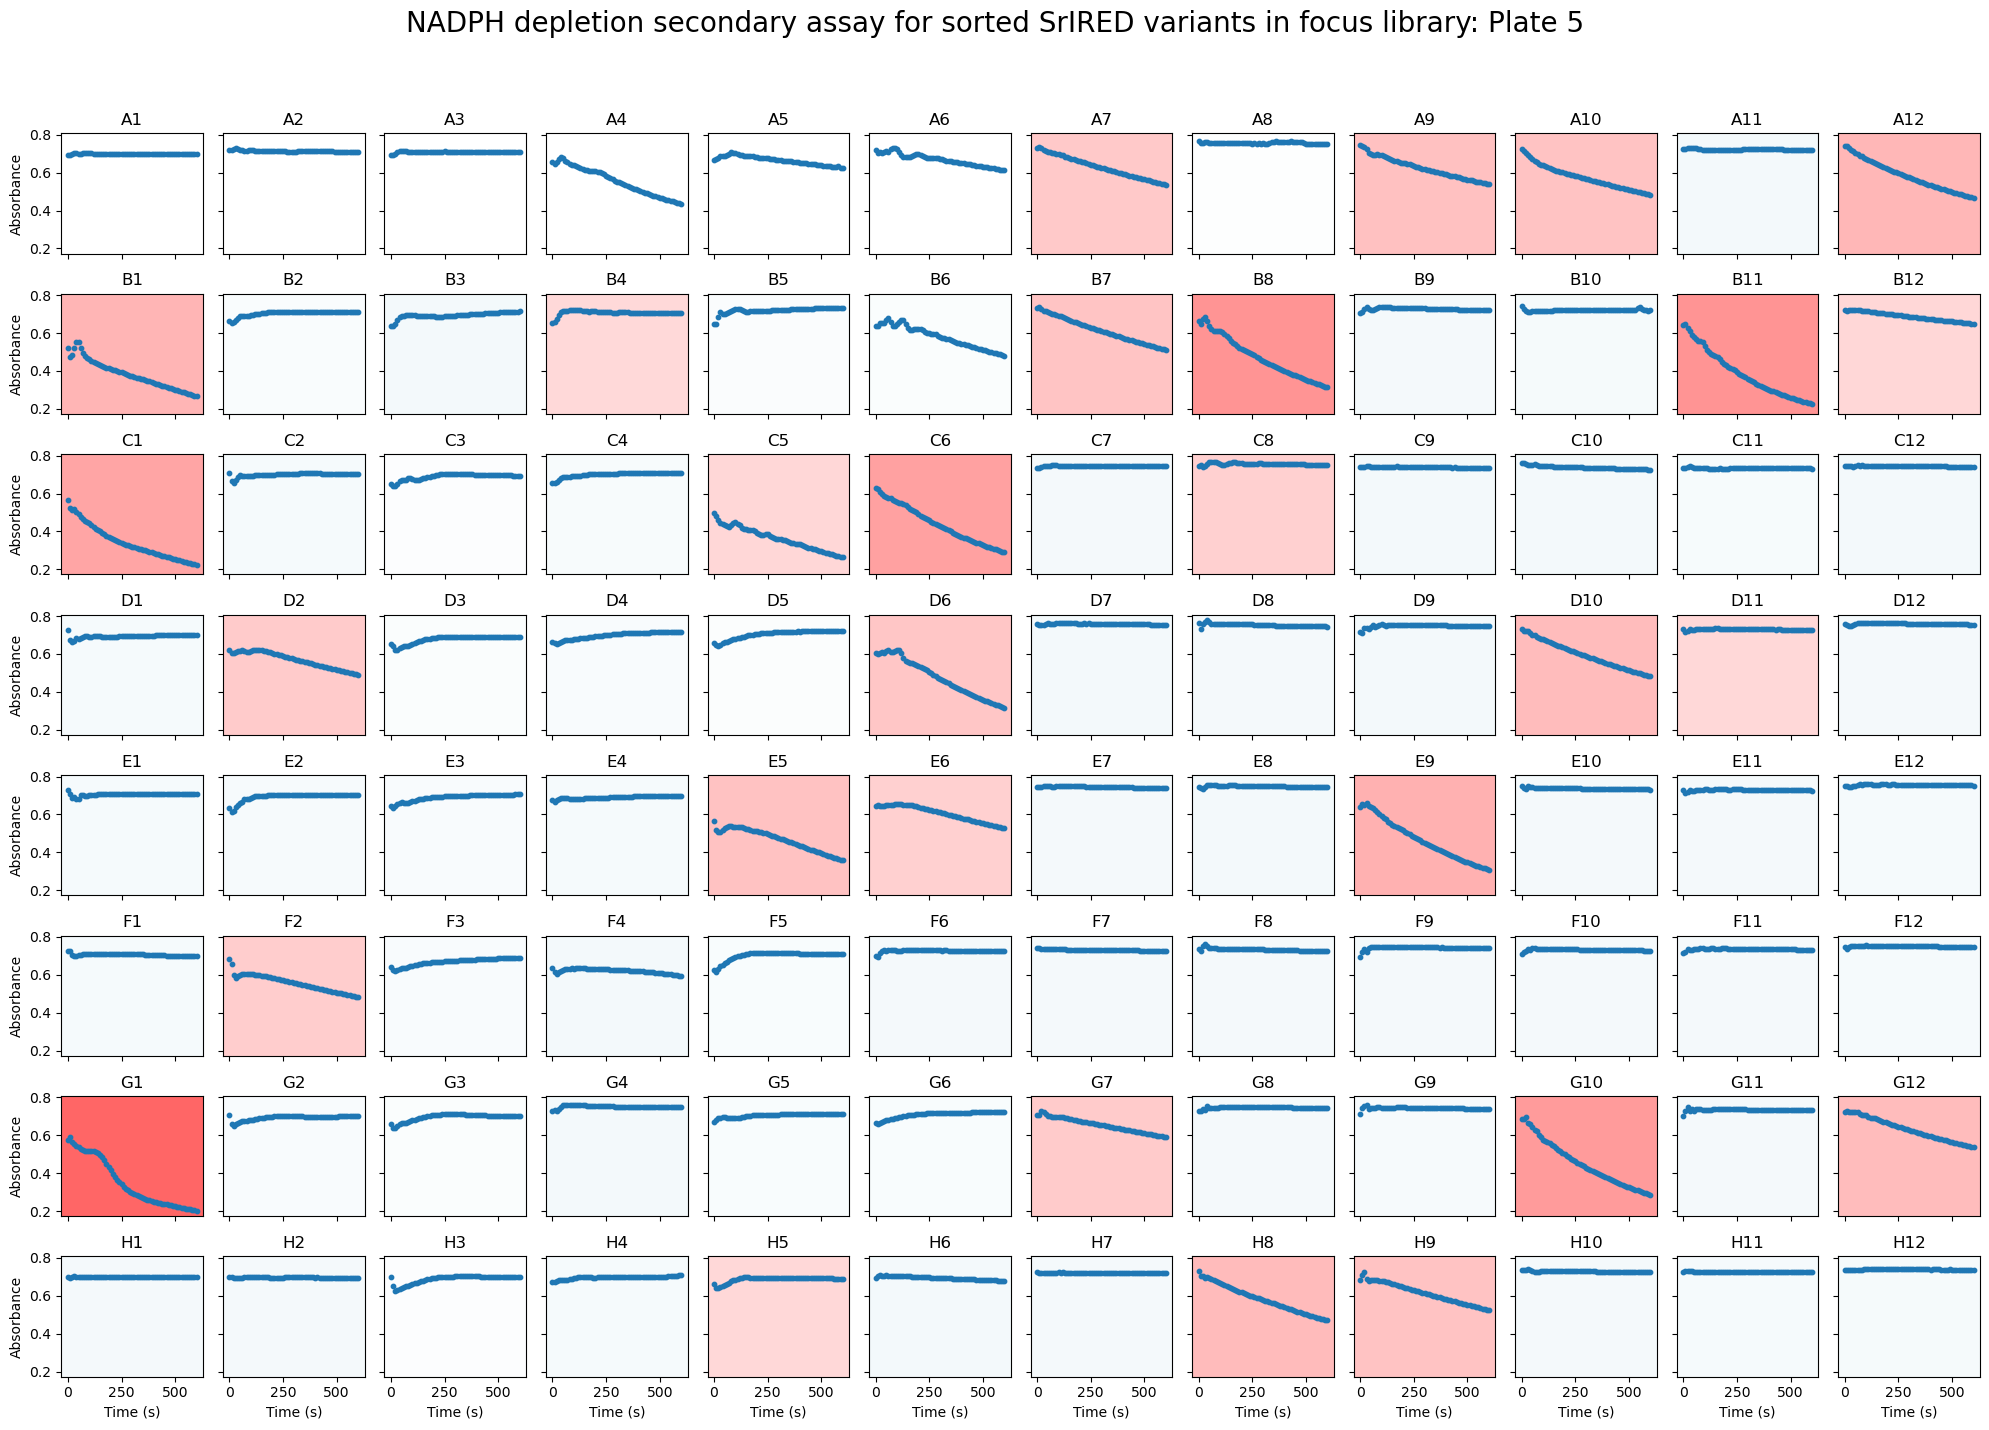

In [5]:
# Normalize the Ratio_to_WT values from 0 to 1
min_ratio = slopes_df['Ratio_to_WT'].min()
max_ratio = slopes_df['Ratio_to_WT'].max()
slopes_df['Normalized_Ratio_to_WT'] = (slopes_df['Ratio_to_WT'] - min_ratio) / (max_ratio - min_ratio)

# Define the color map
def ratio_to_color(ratio,normalized_ratio):
    if ratio < 1:
        return mcolors.to_rgba('lightblue', alpha=0.6 * normalized_ratio)
    elif ratio == 1:
        return mcolors.to_rgba('white', alpha=0.6)
    else:
        return mcolors.to_rgba('red', alpha=0.6 * normalized_ratio)

# Create a figure with 96 subplots (8x12 grid)
fig, axes = plt.subplots(8, 12, figsize=(20, 15), sharex=True, sharey=True)
fig.suptitle('NADPH depletion secondary assay for sorted SrIRED variants in focus library: Plate 5', fontsize=20)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each well in a subplot
for i, well in enumerate(well_data.columns):
    ax = axes[i]
    ax.scatter(time_data, df[well], s=10)
    ax.set_title(well)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Absorbance')
    ax.label_outer()
    
    # Set background color based on Normalized_Ratio_to_WT
    if well in negative_controls + wild_type_controls:
        ax.set_facecolor('white')
    else:
        ratio = slopes_df[slopes_df['Well'] == well]['Ratio_to_WT'].values[0]
        normalized_ratio = slopes_df[slopes_df['Well'] == well]['Normalized_Ratio_to_WT'].values[0]
        ax.set_facecolor(ratio_to_color(ratio,normalized_ratio))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Save the figure
figure_path = "/Users/Zachary/Library/CloudStorage/OneDrive-UniversityofCambridge/Project/Focused_Library/secondary_assay/plate_5_result.png"
plt.savefig(figure_path)

# Save the slopes_df dataframe to a CSV file
csv_path = "/Users/Zachary/Library/CloudStorage/OneDrive-UniversityofCambridge/Project/Focused_Library/secondary_assay/plate_5_slope.csv"
slopes_df.to_csv(csv_path, index=False)

plt.show()